### 1\. Import các thư viện cần thiết

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

### 2\. Thiết lập cơ bản

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!nvidia-smi

### 3\. Đọc dữ liệu

#### 3\.1 Đọc dữ liệu bằng hàm xây dựng sẵn của Tensorflow

In [3]:
img_size = 224
batch_size= 20

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory='archive/train', labels='inferred',
    label_mode='categorical', class_names=None, batch_size=batch_size,
    image_size=(img_size,img_size), shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory='archive/valid', labels='inferred',
    label_mode='categorical', class_names=None, batch_size=batch_size,
    image_size=(img_size,img_size), shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory='archive/test', labels='inferred',
    label_mode='categorical', class_names=None, batch_size=batch_size,
    image_size=(img_size,img_size), shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False
)

Found 1535 files belonging to 10 classes.
Found 50 files belonging to 10 classes.
Found 50 files belonging to 10 classes.


#### 3\.2 Hiển thị một số hình ảnh

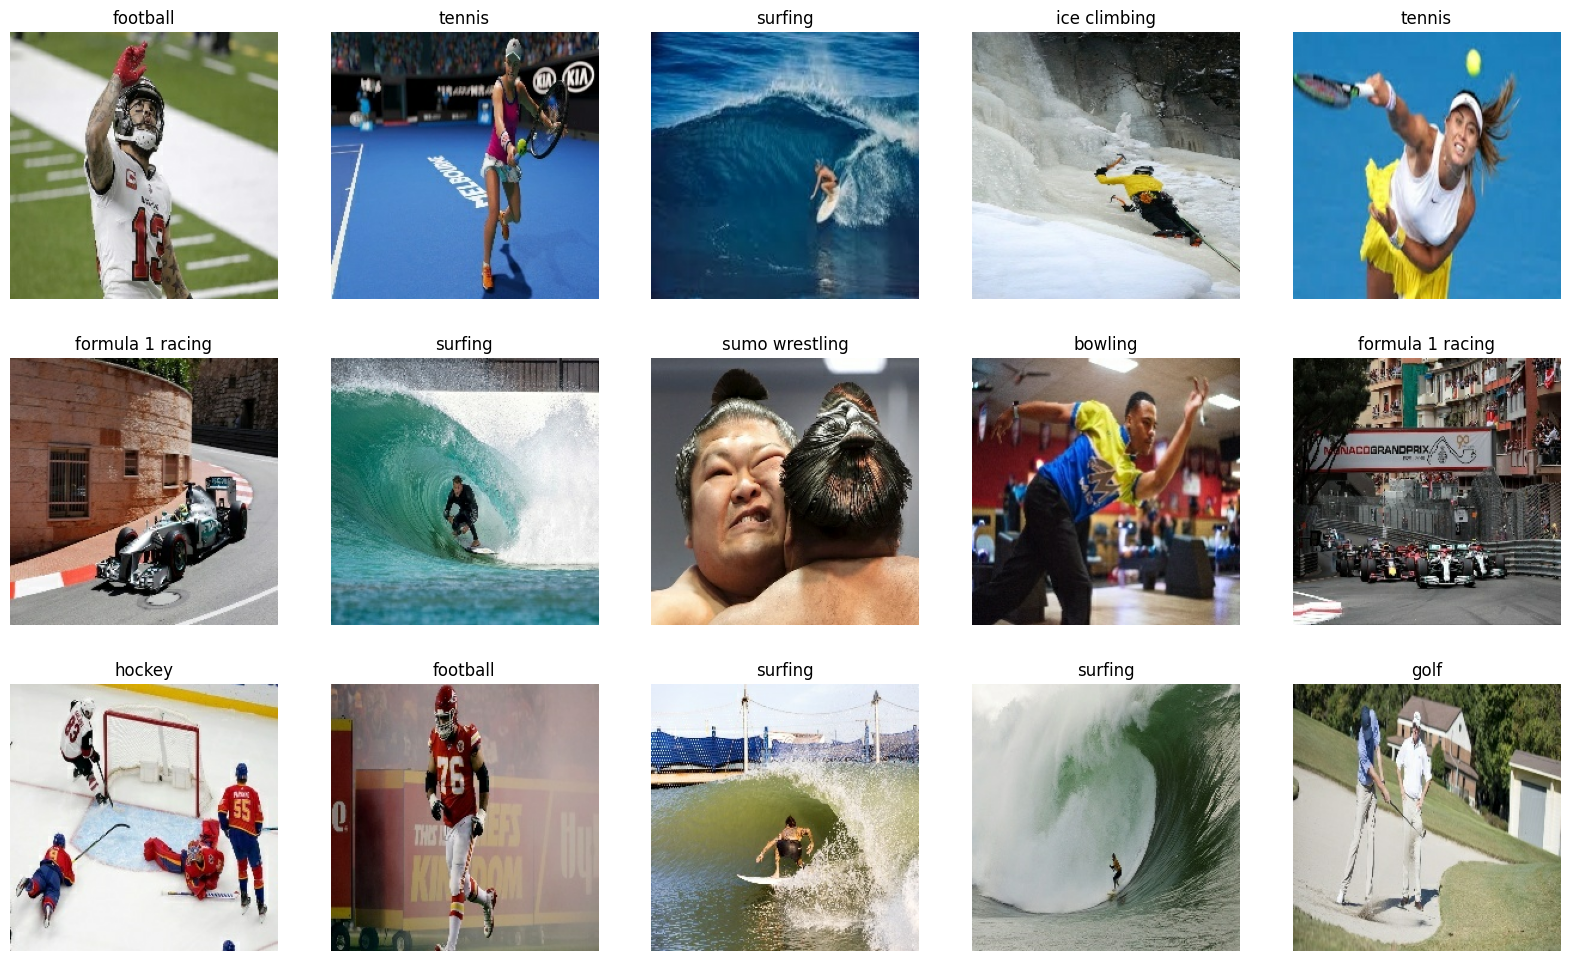

In [4]:
plt.rcParams['figure.figsize']= (20,8)

class_names = train_data.class_names
plt.figure(figsize=(20,12))
for x in train_data.take(1):
    for i in range(15):
        plt.subplot(3,5,i+1)
        image = x[0][i] / 255.
        plt.imshow(image)
        label_index = np.argmax(x[1][i].numpy())
        plt.title(class_names[label_index])
        plt.axis('off')

### 4\. Xây dựng mô hình

#### 4\.1 Thiết kế mô hình

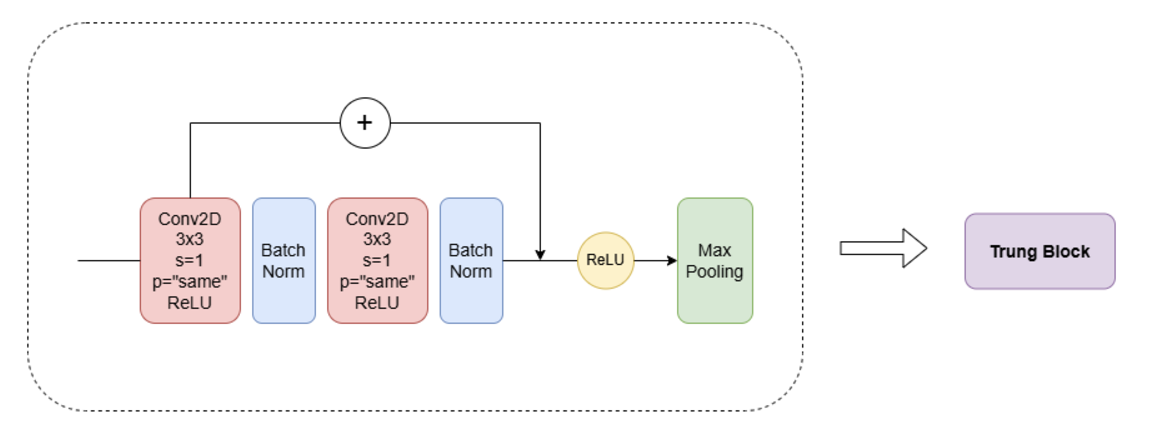

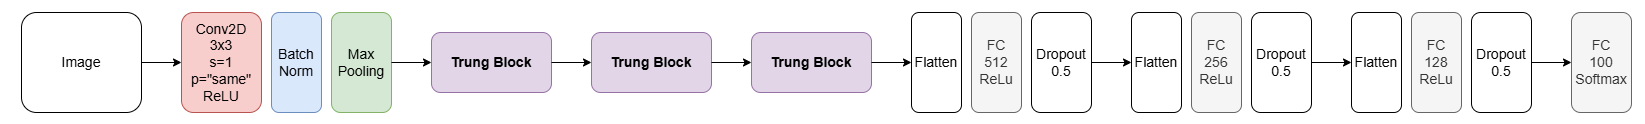

#### 4\.2 Xây dựng mô hình bằng Tensorflow

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Input, Add, Activation

def residual_block(x, filters, kernel_size=(3, 3), stride=1):
    shortcut = x
    # Convolution Block
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, strides=1, padding='same', activation=None)(x)
    x = BatchNormalization()(x)
    
    # Điều chỉnh shortcut nếu cần (để có số lượng filters giống nhau)
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same', activation=None)(shortcut)
    
    # Cộng shortcut và kết quả
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_model(input_shape=(224, 224, 3), num_classes=100):
    inputs = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), strides=1, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Block 2 (với Residual Block)
    x = residual_block(x, 128)
    x = MaxPooling2D((2, 2))(x)

    # Block 3 (với Residual Block)
    x = residual_block(x, 256)
    x = MaxPooling2D((2, 2))(x)

    # Block 4 (với Residual Block)
    x = residual_block(x, 512)
    x = MaxPooling2D((2, 2))(x)

    # Fully Connected Layers
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output Layer cho 100 lớp
    outputs = Dense(num_classes, activation='softmax')(x)

    # Tạo mô hình
    model = Model(inputs, outputs)
    
    return model

#### 4\.3 Khởi tạo mô hình

In [6]:
model = build_model(num_classes=10)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

### 5\. Huấn luyện mô hình

### 5\.1 Thiết lập các thành phần tối ưu mô hình

In [7]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#### 5\.2 Tiến hành huấn luyện

In [8]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
)

Epoch 1/20
 6/77 [=>............................] - ETA: 10:32 - loss: 3.4634 - accuracy: 0.1667

KeyboardInterrupt: 

#### 5\.3 Kết quả huấn luyện

In [ ]:
def plot_history(history):
    history_dict = history.history

    fig, ax = plt.subplots(1, 2, figsize=(30, 10))

    ax[0].plot(list(range(len(history_dict['loss']))), history_dict["loss"], 'ro-', lw=3, markersize=8, label="training loss")
    ax[0].plot(list(range(len(history_dict['loss']))), history_dict["val_loss"], 'b^-', lw=3, markersize=8, label="validation loss")

    ax[1].plot(list(range(len(history_dict['loss']))), history_dict["accuracy"], 'ro-', lw=3, markersize=8, label="training accuracy")
    ax[1].plot(list(range(len(history_dict['loss']))), history_dict["val_accuracy"], 'b^-', lw=3, markersize=8, label="validation accuracy")

    ax[0].legend(loc="upper right")
    ax[1].legend(loc="upper left")

    ax[0].set_xlabel("epochs", fontsize=12, weight='bold')
    ax[1].set_xlabel("epochs", fontsize=12, weight='bold')

    ax[0].set_ylabel("loss", fontsize=12, weight='bold')
    ax[1].set_ylabel("accuracy", fontsize=12, weight='bold')

    fig.text(0.515, .93, "Model learning curves", ha="center", va="top", fontsize=18, weight='bold')
    plt.show()

In [ ]:
plot_history(history)

### 6\. Kiểm thử mô hình

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

y_true = []
y_pred = []

batch_index = 0
for batch_images, batch_labels in test_data:
    print(f"Tiến hành dự đoán cho batch số {batch_index+1}:")
    batch_index += 1

    true_labels = np.argmax(batch_labels, axis=1)

    predictions = model.predict(batch_images)
    predicted_labels = np.argmax(predictions, axis=1)

    y_true.extend(true_labels)
    y_pred.extend(predicted_labels)

# Chuyển đổi thành mảng numpy
y_true = np.array(y_true)
y_pred = np.array(y_pred)
# Tính toán Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Tính toán Precision và Recall
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print("===================================")
print("Kết quả cuối cùng:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
